In [1]:
# Importing all the necessary libraries

import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.model_selection import StratifiedKFold,GridSearchCV 
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier      
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import SimpleImputer


path= r'C:\Users\HP\Desktop\backorder project\artifacts\train.csv'         # Use the path of your saved dataset for avoiding errors
train_data= pd.read_csv(path)

path= r'C:\Users\HP\Desktop\backorder project\artifacts\test.csv'             # Use the path of your saved dataset for avoiding errors
test_data= pd.read_csv(path)

train_data= train_data.drop(['forecast_6_month', 'forecast_9_month','sales_3_month', 'sales_6_month', 'sales_9_month','perf_12_month_avg'],axis=1)    #Avoiding Multicollinearity

num_cols= [0,1,2,3,4,5,7,8,9]               #The index number of each column is required for transformations
cat_cols= [6,10,11,12,13,14,15]

# To handle missing values and transform data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('impute', SimpleImputer(strategy='median')),
            ('power_transform', PowerTransformer())
        ]), num_cols),

        ('cat', Pipeline(steps=[
            ('impute', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(drop='if_binary'))
        ]), cat_cols)
    ],
    remainder='passthrough' 
)                                                         

train_data= preprocessor.fit_transform(train_data)
train_data= pd.DataFrame(train_data)

X= train_data.drop([15],axis=1)                            
y= train_data[15]

skf= StratifiedKFold(random_state=42,shuffle=True)                  #Stratified KFold cross val splits for hyperparamter tuning and for getting mean train scores
scaler= StandardScaler()

# Performing the same operation done for train data

test_data= test_data.drop(['forecast_6_month', 'forecast_9_month','sales_3_month', 'sales_6_month', 'sales_9_month','perf_12_month_avg'],axis=1)                                                          

test_data= preprocessor.transform(test_data)
test_data= pd.DataFrame(test_data)

X_test= test_data.drop([15],axis=1)                            
y_test= test_data[15]

Backorder occurs when a customer places an order for a product, but the product is not currently available in stock to fulfill the order. The order is essentially delayed and is fulfilled only after the stock is replenished .
Usually in industries that track backorders want to predict future or possible backordered products to keep the extra stock in hand to avoid supply chain disruptions, operational strain, customer dissatisfaction. Whenever an industry attempts to build a model to predict a backordered product, being a classification problem, there exist multiple possible ways to access the best possible model in terms of performance.

However in this scenario where calculating the possibility of product going backordered (positive class) is seen rare and thus the model should be able to predict them and not get biased towards the neagtive class due to their dominance over the dataset. 
AUC ROC and PR ROC are the two metrics that are used to access the model performance over various classsification thresholds. The ROC curve access the performance of the model to distinguish between the to classes and calculates the True positive rate(Recall) and False positive rate of the model at various classification thresholds to get the holistic view of the model performance whereas the PR curve calculates the model's precision and recall at various thresholds to access the model's performance. In this problem, focusing more on PR curve can be seen beneficial due to the imbalanced nature of the data and the ability of the PR curve to focus more on the positive class.

Since in this problem a miss(False Negative) is considered more costlier than a false alarm(False Positive) as predicting a product going to backorder when it will not, would not affect the supply chain inventory and operations as much as when a product is predicted not going to backorder but it would eventually go. Thus the other metric to focus for accessing the model performance would be recall or sensitivity.

Different models have been trained and the best models in terms of performance and classification report are used for model selection. The models that are going to be used for final model selection considering the balancing methods are:-

--> Models with RUS:-
1) Log Model 
2) Linear SVM
3) Decision Tree
4) Random Forest
5) GBoost
6) XGBoost
7) Lightgbm

--> Models with ROS:-
1) GBoost
2) XGBoost

--> Ensemble techniques
1) Balanced Random Forest
2) Easy Ensemble

##### Let's find out the best model which undergoes RUS balancing:-

Logistic Model

In [2]:
import warnings
warnings.filterwarnings('ignore')                                                           

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('undersamp', RandomUnderSampler(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42))
])

param_grid={
    'classifier__penalty':['l1','l2','elasticnet'],
    'classifier__solver':['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'classifier__C':[1,0.1,0.01,10],
    'classifier__l1_ratio':[0,1,0.5]
}

grid_lr= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='roc_auc',n_jobs=-1)
grid_lr.fit(X,y)
log_model= grid_lr.best_estimator_

best_index= grid_lr.best_index_
results = pd.DataFrame(grid_lr.cv_results_)

print("Logistic Train ROC AUC Score:", grid_lr.best_score_)  # Best estimator's ROC AUC (used for refit)
print("Logistic Train PR AUC Score:", results['mean_test_pr_auc'][best_index])   # Best estimator's PR score
print("Logistic Model Parameters:", grid_lr.best_params_)

Logistic Train ROC AUC Score: 0.8930765588551349
Logistic Train PR AUC Score: 0.0777746476143923
Logistic Model Parameters: {'classifier__C': 10, 'classifier__l1_ratio': 0, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky'}


Logistic Test ROC Score:  0.865893727834149
Logistic Test PR Score:  0.04184129235080165
              precision    recall  f1-score   support

         0.0       1.00      0.71      0.83    383192
         1.0       0.02      0.89      0.04      2796

    accuracy                           0.71    385988
   macro avg       0.51      0.80      0.44    385988
weighted avg       0.99      0.71      0.83    385988



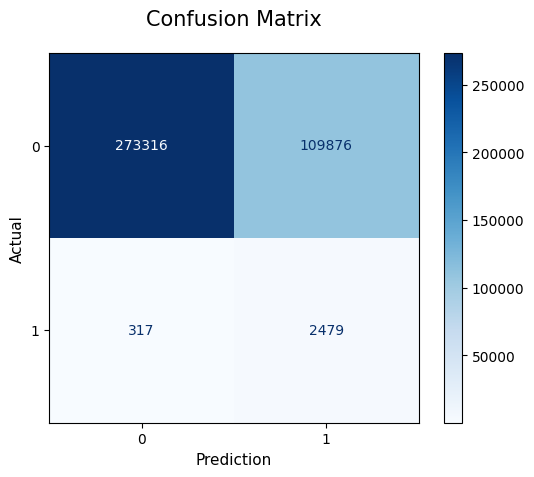

In [3]:
_  = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

y_pred= log_model.predict_proba(X_test_scaled)[:, 1]
y_predict= log_model.predict(X_test_scaled)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Logistic Test ROC Score: ',roc_auc)
print('Logistic Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

LinearSVC

In [4]:
import warnings
warnings.filterwarnings('ignore')

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('undersamp', RandomUnderSampler(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', LinearSVC(random_state=42))
])

param_grid={
    'classifier__penalty':['l1','l2'],
    'classifier__C':[1,0.1,0.01,10],
    'classifier__loss':['squared_hinge', 'hinge']
}

grid_svm_und= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='pr_auc',n_jobs=-1)
grid_svm_und.fit(X,y)
svm_model_und= grid_svm_und.best_estimator_

best_index= grid_svm_und.best_index_
results = pd.DataFrame(grid_svm_und.cv_results_)

print("LinearSVC Train PR AUC Score:", grid_svm_und.best_score_)  # Best estimator's PR AUC (used for refit)
print("LinearSVC Train ROC AUC Score:", results['mean_test_roc_auc'][best_index])   # Best estimator's ROC score
print("LinearSVC Model Parameters:", grid_svm_und.best_params_)

LinearSVC Train PR AUC Score: 0.07866303128829799
LinearSVC Train ROC AUC Score: 0.8915220191879033
LinearSVC Model Parameters: {'classifier__C': 1, 'classifier__loss': 'hinge', 'classifier__penalty': 'l2'}


SVC with Undersampling Test ROC Score:  0.8753673821400125
SVC with Undersampling Test PR Score:  0.05766040450814519
              precision    recall  f1-score   support

         0.0       1.00      0.81      0.89    383192
         1.0       0.03      0.82      0.06      2796

    accuracy                           0.81    385988
   macro avg       0.51      0.81      0.48    385988
weighted avg       0.99      0.81      0.89    385988



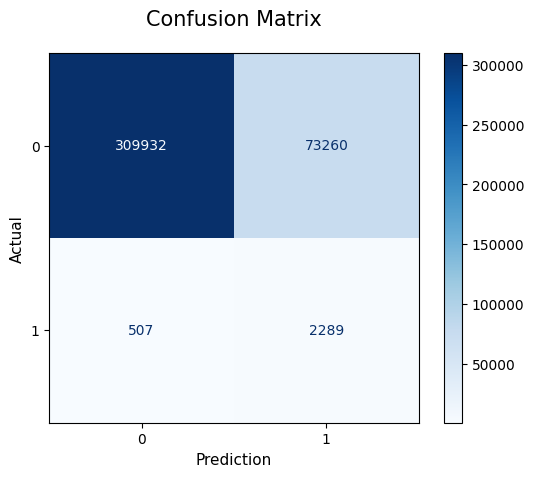

In [5]:
_  = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

y_pred= svm_model_und.decision_function(X_test_scaled)
y_predict= svm_model_und.predict(X_test_scaled)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('SVC with Undersampling Test ROC Score: ',roc_auc)
print('SVC with Undersampling Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

Linear models perform similar both on train,test roc/pr score as well as on confusion matrix. Though Log model has slight better recall but their performance overall are quite similar.

Let's have a look on the tree models:-

Decision Tree

In [6]:
scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('undersamp',RandomUnderSampler(random_state=42)),
    ('cart', DecisionTreeClassifier(random_state=42))
])

param_grid={
    'cart__max_depth':[3,4,5,7,10,15,20,30,50],
    'cart__max_features':[3,5,10,None],
    'cart__criterion': ['entropy','gini'],
    'cart__min_samples_leaf':[1,5]
}

grid_dt_rus= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='pr_auc',n_jobs=-1)
grid_dt_rus.fit(X,y)
dt_model_rus= grid_dt_rus.best_estimator_

best_index= grid_dt_rus.best_index_
results = pd.DataFrame(grid_dt_rus.cv_results_)

print("Decision Tree Train PR AUC Score:", grid_dt_rus.best_score_)  # Best estimator's PR AUC (used for refit)
print("Decision Tree Train ROC AUC Score:", results['mean_test_roc_auc'][best_index])   # Best estimator's ROC score
print("Decision Tree Model Parameters:", grid_dt_rus.best_params_)

Decision Tree Train PR AUC Score: 0.10843256844808302
Decision Tree Train ROC AUC Score: 0.9228629123892309
Decision Tree Model Parameters: {'cart__criterion': 'gini', 'cart__max_depth': 7, 'cart__max_features': None, 'cart__min_samples_leaf': 5}


DT with RUS Test ROC Score:  0.9257262837321234
DT with RUS Test PR Score:  0.10431794978347911
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93    383192
         1.0       0.05      0.85      0.09      2796

    accuracy                           0.87    385988
   macro avg       0.52      0.86      0.51    385988
weighted avg       0.99      0.87      0.92    385988



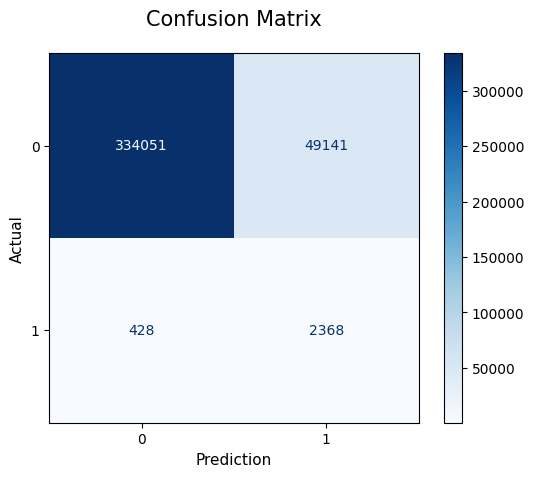

In [7]:
y_pred= dt_model_rus.predict_proba(X_test)[:, 1]
y_predict= dt_model_rus.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('DT with RUS Test ROC Score: ',roc_auc)
print('DT with RUS Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

Random Forest

In [8]:
scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('undersamp',RandomUnderSampler(random_state=42)),
    ('forest', RandomForestClassifier(n_estimators=10,min_samples_leaf=5,random_state=42))
])

param_grid={
    'forest__max_depth':[3,4,5,7,10,15,20,30,50],
    'forest__criterion':['gini','entropy']
}

grid_rf_und= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='pr_auc',n_jobs=-1)
grid_rf_und.fit(X,y)
rf_model_und= grid_rf_und.best_estimator_

best_index= grid_rf_und.best_index_
results = pd.DataFrame(grid_rf_und.cv_results_)

print("Random Forest Train PR AUC Score:", grid_rf_und.best_score_)  # Best estimator's PR AUC (used for refit)
print("Random Forest Train ROC AUC Score:", results['mean_test_roc_auc'][best_index])   # Best estimator's ROC score
print("Random Forest Model Parameters:", grid_rf_und.best_params_)

Random Forest Train PR AUC Score: 0.15718754404693816
Random Forest Train ROC AUC Score: 0.93837313245632
Random Forest Model Parameters: {'forest__criterion': 'entropy', 'forest__max_depth': 15}


Random Forest with RUS Test ROC Score:  0.9362654549797662
Random Forest with RUS Test PR Score:  0.13092052264258192
              precision    recall  f1-score   support

         0.0       1.00      0.86      0.93    383192
         1.0       0.04      0.88      0.08      2796

    accuracy                           0.86    385988
   macro avg       0.52      0.87      0.50    385988
weighted avg       0.99      0.86      0.92    385988



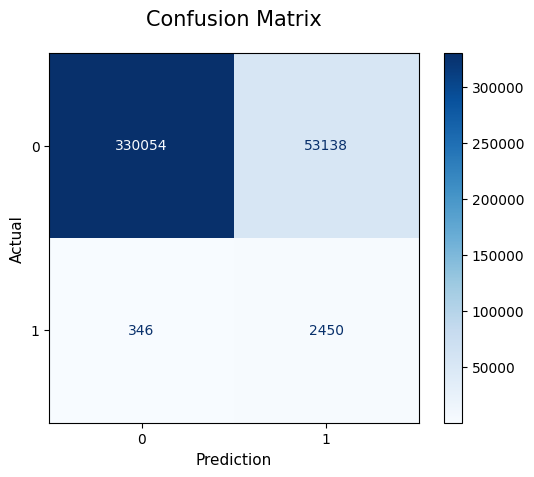

In [9]:
y_pred= rf_model_und.predict_proba(X_test)[:, 1]
y_predict= rf_model_und.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Random Forest with RUS Test ROC Score: ',roc_auc)
print('Random Forest with RUS Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

Gradient Boost

In [10]:
scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('rus',RandomUnderSampler(random_state=42)),
    ('gboost', GradientBoostingClassifier(n_estimators=10,min_samples_leaf=5,random_state=42))
])

param_grid={
    'gboost__max_depth':[3,4,5,7,10,15,20,30,50]
}

grid_gb_und= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='pr_auc',n_jobs=-1)
grid_gb_und.fit(X,y)
gb_model_und= grid_gb_und.best_estimator_

best_index= grid_gb_und.best_index_
results = pd.DataFrame(grid_gb_und.cv_results_)

print("Gradient Boost Train PR AUC Score:", grid_gb_und.best_score_)  # Best estimator's PR AUC (used for refit)
print("Gradient Boost Train ROC AUC Score:", results['mean_test_roc_auc'][best_index])   # Best estimator's ROC score
print("Gradient Boost Train Parameters:", grid_gb_und.best_params_)

Gradient Boost Train PR AUC Score: 0.15636164372897668
Gradient Boost Train ROC AUC Score: 0.9362622164887583
Gradient Boost Train Parameters: {'gboost__max_depth': 7}


GBoost RUS Test ROC Score:  0.9366647685606108
GBoost RUS Test PR Score:  0.13958916870749788
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93    383192
         1.0       0.05      0.87      0.09      2796

    accuracy                           0.87    385988
   macro avg       0.52      0.87      0.51    385988
weighted avg       0.99      0.87      0.92    385988



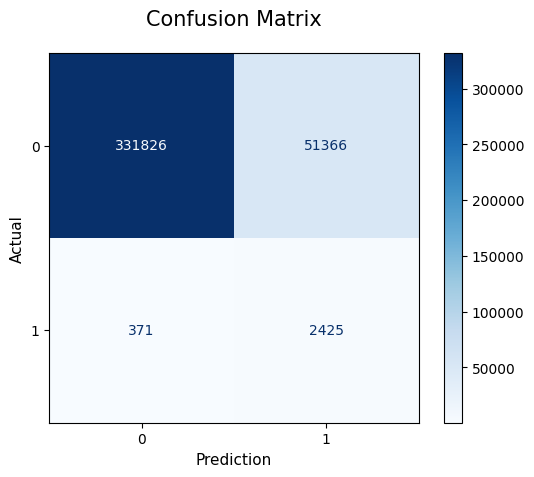

In [11]:
y_pred= gb_model_und.predict_proba(X_test)[:, 1]
y_predict= gb_model_und.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('GBoost RUS Test ROC Score: ',roc_auc)
print('GBoost RUS Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

Though Tree models perform slightly better than linear ones, amongst them, all have somewhat similar scores and classification reports.Let's compare them with XGBoost and Lightgbm.

XGBoost

In [12]:
xgb_model_und = xgb.XGBClassifier(random_state=42)                  
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    ran_under = RandomUnderSampler(random_state=42)
    X_train_und, y_train_und = ran_under.fit_resample(X_train, y_train)

    xgb_model_und.fit(X_train_und,y_train_und)
    y_pred= xgb_model_und.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

print(f'XGBoost Train Roc score: {sum(roc_score)/len(roc_score)}')
print(f'XGBoost Train PR score: {sum(pr_score)/len(pr_score)}')

XGBoost Train Roc score: 0.9436897065756007
XGBoost Train PR score: 0.1609666980872956


XGBoost RUS Test ROC Score:  0.9431749118712208
XGBoost RUS Test PR Score:  0.14939027119445472
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93    383192
         1.0       0.05      0.88      0.09      2796

    accuracy                           0.87    385988
   macro avg       0.52      0.88      0.51    385988
weighted avg       0.99      0.87      0.92    385988



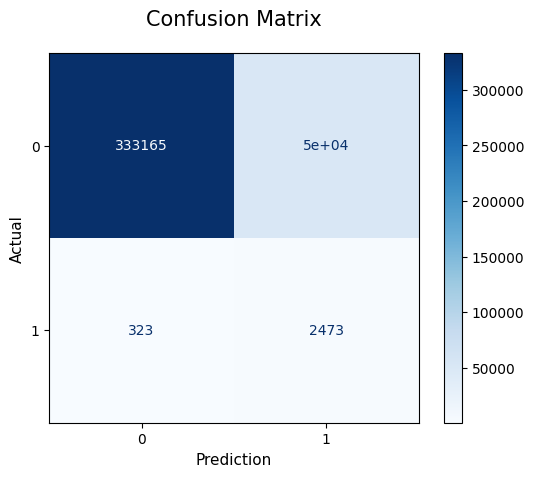

In [13]:
y_pred= xgb_model_und.predict_proba(X_test)[:, 1]
y_predict= xgb_model_und.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('XGBoost RUS Test ROC Score: ',roc_auc)
print('XGBoost RUS Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

LightGBM

In [14]:
lgb_model_und = lgb.LGBMClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    und= RandomUnderSampler(random_state=42)
    X_train_und,y_train_und= und.fit_resample(X_train,y_train)

    lgb_model_und.fit(X_train_und,y_train_und)
    y_pred= lgb_model_und.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

print(f'LightGBM Train Roc score: {sum(roc_score)/len(roc_score)}')
print(f'LightGBM Train PR score: {sum(pr_score)/len(pr_score)}')

[LightGBM] [Info] Number of positive: 8948, number of negative: 8948
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1417
[LightGBM] [Info] Number of data points in the train set: 17896, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 8948, number of negative: 8948
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1416
[LightGBM] [Info] Number of data points in the train set: 17896, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.00000

LGBM RUS Test ROC Score:  0.9442604767905322
LGBM RUS Test PR Score:  0.1633837886350883
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93    383192
         1.0       0.05      0.89      0.09      2796

    accuracy                           0.87    385988
   macro avg       0.52      0.88      0.51    385988
weighted avg       0.99      0.87      0.92    385988



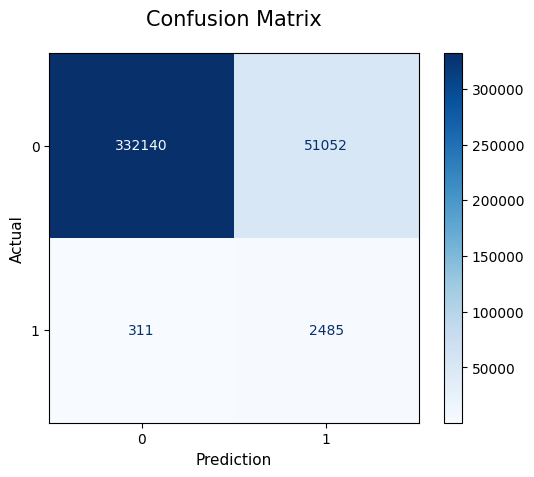

In [15]:
y_pred= lgb_model_und.predict_proba(X_test)[:, 1]
y_predict= lgb_model_und.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('LGBM RUS Test ROC Score: ',roc_auc)
print('LGBM RUS Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

All tree models have similar scores when compared amongst themselves, but all perform better than linear models. The comparison can be further extended by looking over their feature importances. But before that

##### Let's find out the best model that undergoes ROS balancing

XGBoost

In [16]:
xgb_model_ovr = xgb.XGBClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    ovr= RandomOverSampler(random_state=42)
    X_train_ovr,y_train_ovr= ovr.fit_resample(X_train,y_train)

    xgb_model_ovr.fit(X_train_ovr,y_train_ovr)
    y_pred= xgb_model_ovr.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

print(f'XGBoost Train Roc score: {sum(roc_score)/len(roc_score)}')
print(f'XGBoost Train PR score: {sum(pr_score)/len(pr_score)}')

XGBoost Train Roc score: 0.9441761673576942
XGBoost Train PR score: 0.21743591582086097


XGBoost ROS Test ROC Score:  0.9452825087688236
XGBoost ROS Test PR Score:  0.2081491330242708
              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95    383192
         1.0       0.06      0.86      0.11      2796

    accuracy                           0.90    385988
   macro avg       0.53      0.88      0.53    385988
weighted avg       0.99      0.90      0.94    385988



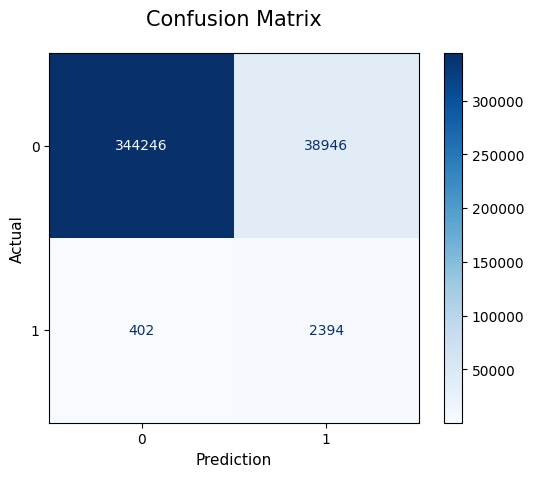

In [17]:
y_pred= xgb_model_ovr.predict_proba(X_test)[:, 1]
y_predict= xgb_model_ovr.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('XGBoost ROS Test ROC Score: ',roc_auc)
print('XGBoost ROS Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

GBoost

In [18]:
scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('oversamp',RandomOverSampler(random_state=42)),
    ('gboost', GradientBoostingClassifier(n_estimators=10,min_samples_leaf=5,random_state=42))
])

param_grid={
    'gboost__max_depth':[3,4,5,7,10,15,20,30,50]
}

grid_gb_ovr= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='roc_auc',n_jobs=-1)
grid_gb_ovr.fit(X,y)
gb_model_ovr= grid_gb_ovr.best_estimator_

best_index= grid_gb_ovr.best_index_
results = pd.DataFrame(grid_gb_ovr.cv_results_)

print("GBoost Train ROC AUC Score:", grid_gb_ovr.best_score_)  # Best estimator's ROC AUC (used for refit)
print("GBoost Train PR AUC Score:", results['mean_test_pr_auc'][best_index])   # Best estimator's PR score
print("GBoost Model Parameters:", grid_gb_ovr.best_params_)

GBoost Train ROC AUC Score: 0.9378903289087406
GBoost Train PR AUC Score: 0.18350017333413032
GBoost Model Parameters: {'gboost__max_depth': 10}


GBoost ROS Test ROC Score:  0.9421765497507109
GBoost ROS Test PR Score:  0.17972264714020586
              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94    383192
         1.0       0.05      0.86      0.10      2796

    accuracy                           0.89    385988
   macro avg       0.53      0.88      0.52    385988
weighted avg       0.99      0.89      0.94    385988



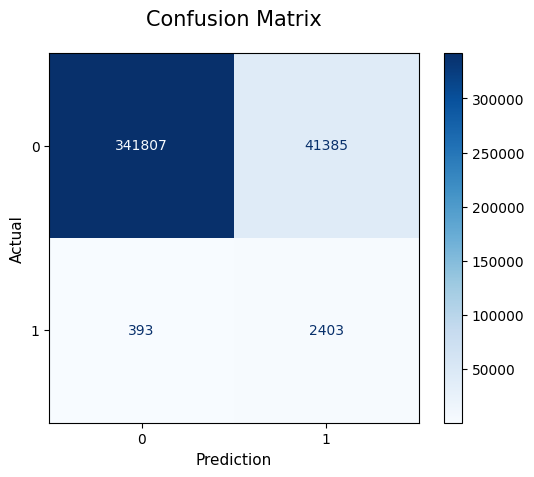

In [19]:
y_pred= gb_model_ovr.predict_proba(X_test)[:, 1]
y_predict= gb_model_ovr.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('GBoost ROS Test ROC Score: ',roc_auc)
print('GBoost ROS Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

Both RUS & ROS for Tree models resulted in good performance overall where RUS being slighlty better than ROS

Balanced Random Forest

In [20]:
brfc_model = BalancedRandomForestClassifier(n_estimators=200,bootstrap=True,replacement=False,sampling_strategy='auto',random_state=42)           
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    brfc_model.fit(X_train,y_train)
    y_pred= brfc_model.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.9538843821560083
PR_score: 0.24723154510919443


BRFC Test ROC Score:  0.9526684050833178
BRFC Test PR Score:  0.2330570480096023
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93    383192
         1.0       0.05      0.92      0.09      2796

    accuracy                           0.87    385988
   macro avg       0.52      0.89      0.51    385988
weighted avg       0.99      0.87      0.92    385988



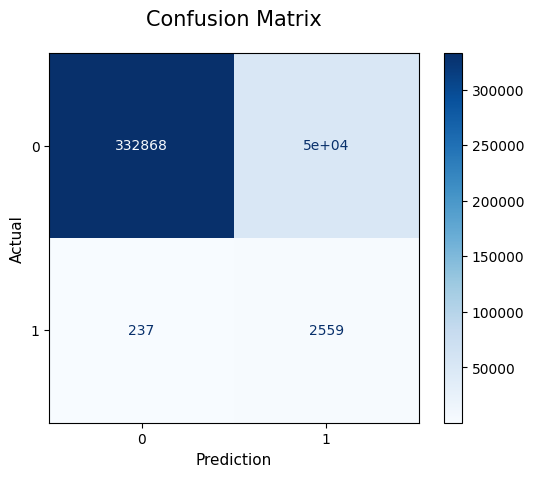

In [21]:
y_pred= brfc_model.predict_proba(X_test)[:, 1]
y_predict= brfc_model.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('BRFC Test ROC Score: ',roc_auc)
print('BRFC Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

Easy Ensemble

In [22]:
from imblearn.ensemble import EasyEnsembleClassifier                       

eec_model = EasyEnsembleClassifier(random_state=42)           
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    eec_model.fit(X_train,y_train)
    y_pred= eec_model.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.9234469832122748
PR_score: 0.13709068328711754


EasyEnsemble Test ROC Score:  0.9248032759478911
EasyEnsemble Test PR Score:  0.1364012685565147
              precision    recall  f1-score   support

         0.0       1.00      0.86      0.93    383192
         1.0       0.04      0.85      0.08      2796

    accuracy                           0.86    385988
   macro avg       0.52      0.86      0.50    385988
weighted avg       0.99      0.86      0.92    385988



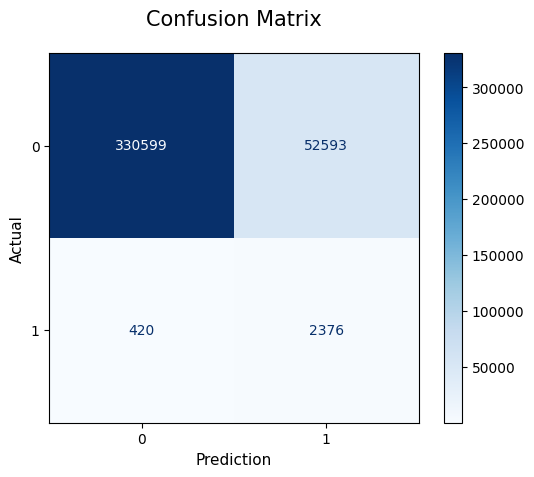

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= eec_model.predict_proba(X_test)[:, 1]
y_predict= eec_model.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('EasyEnsemble Test ROC Score: ',roc_auc)
print('EasyEnsemble Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

Now let's check the feature importance of the tree models:-

These are the columns description that would help in accessing the important features that contribute to the prediction of backorders. These can u used to align the model result with the domain knowledge. It signifies what all majorly contribute to backorder and which areass should we focus to avoid backorder conditions in the future.
> Columns:-
- 0 : 'National inventory'
- 1 : 'Lead time/Transit time'
- 2 : 'In transit quantity',
- 3 : 'Forecasted sales for next 3 months',
- 4 : 'Historical sales over the last month',
- 5 : 'Minimum Quantity of Products required to keep in stock',
- 6 : 'Potential issue with the product',
- 7 : 'No of pieces/products overdued',
- 8 : 'Average Performance over the last 6 month',
- 9 : 'Current Unmet demand of the specific location[local warehouse]',
- 10 to 14 : 'General Risk Flags'


Text(0.5, 1.0, 'Decision Tree RUS')

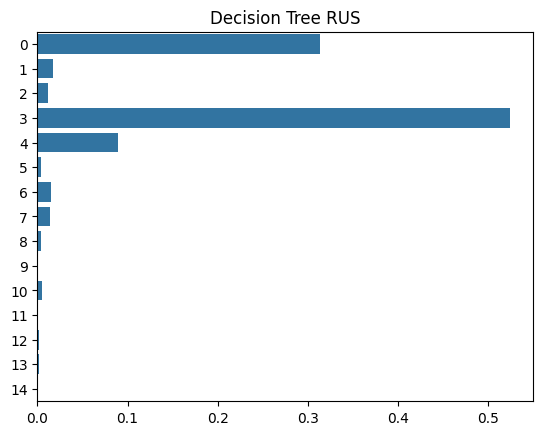

In [24]:
best_dt_model = dt_model_rus.named_steps['cart']
dt_importances = best_dt_model.feature_importances_
sns.barplot(dt_importances,orient='h')
plt.title('Decision Tree RUS')

Text(0.5, 1.0, 'Random Forest RUS')

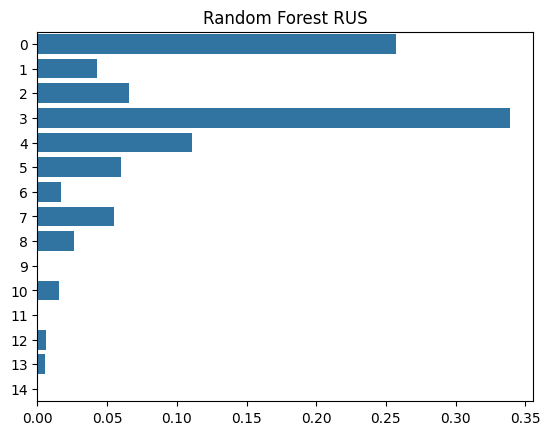

In [25]:
best_rf_model = rf_model_und.named_steps['forest']
rf_importances= best_rf_model.feature_importances_
sns.barplot(rf_importances,orient='h')
plt.title('Random Forest RUS')

Text(0.5, 1.0, 'Gradient Boost RUS')

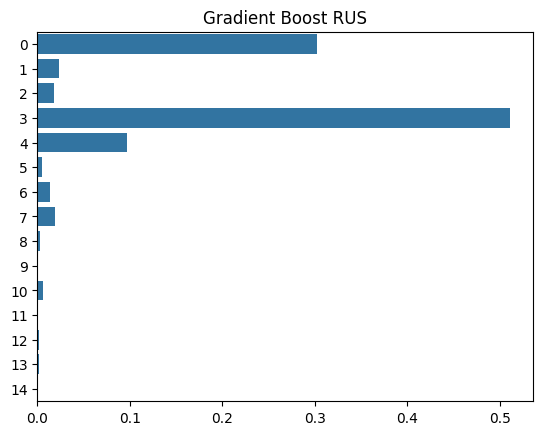

In [26]:
best_gb_model = gb_model_und.named_steps['gboost']
gb_importances= best_gb_model.feature_importances_
sns.barplot(gb_importances,orient='h')
plt.title('Gradient Boost RUS')

Text(0.5, 1.0, 'Gradient Boost ROS')

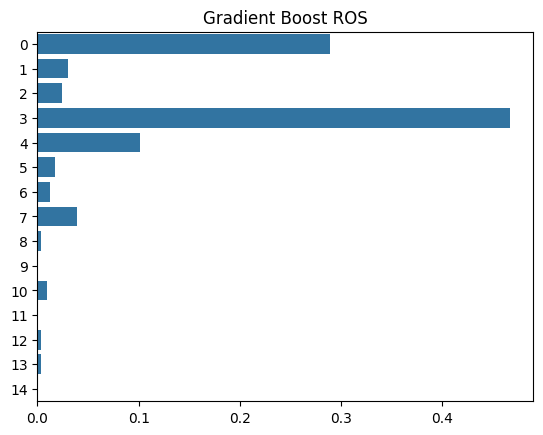

In [27]:
best_gb_model_ovr = gb_model_ovr.named_steps['gboost']
gb_importances_ovr= best_gb_model_ovr.feature_importances_
sns.barplot(gb_importances_ovr,orient='h')
plt.title('Gradient Boost ROS')

Text(0.5, 1.0, 'LGBM RUS')

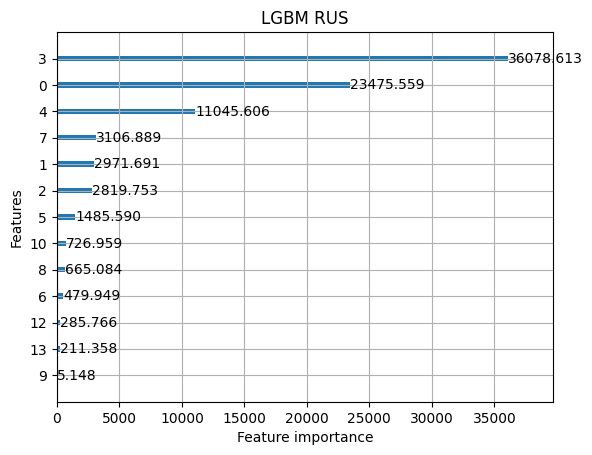

In [28]:
lgb.plot_importance(lgb_model_und, importance_type='gain')
plt.title('LGBM RUS')

Text(0.5, 1.0, 'XGBoost ROS')

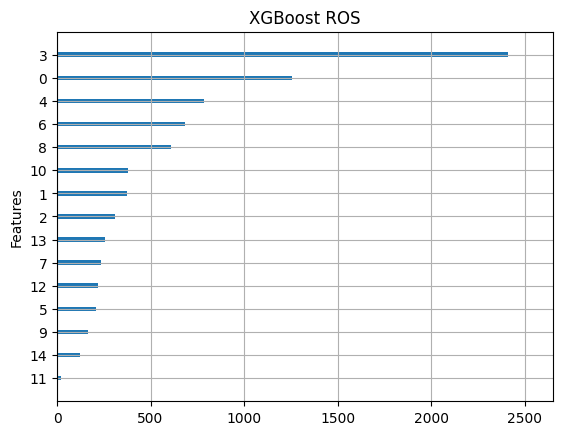

In [29]:
xgb.plot_importance(xgb_model_ovr, importance_type='gain',show_values=False,xlabel=None)
plt.title('XGBoost ROS')

Text(0.5, 1.0, 'XGBoost RUS')

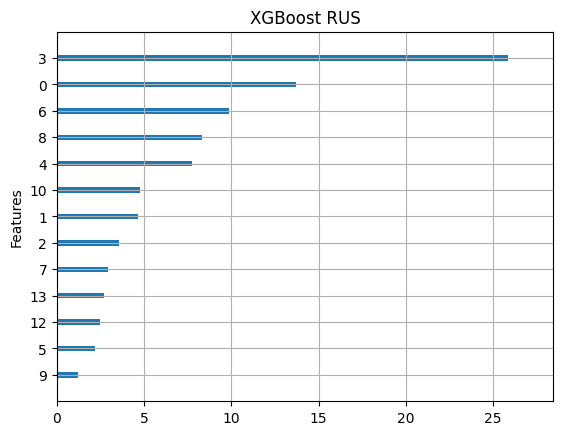

In [30]:
xgb.plot_importance(xgb_model_und, importance_type='gain',show_values=False,xlabel=None)
plt.title('XGBoost RUS')

Text(0.5, 1.0, 'Balanced Random Forest')

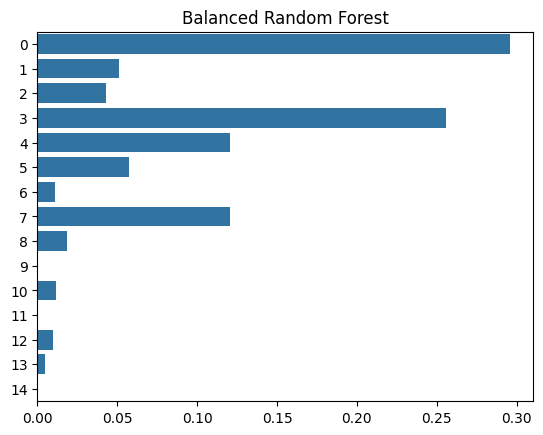

In [31]:
brfc_importances= brfc_model.feature_importances_
sns.barplot(brfc_importances,orient='h')
plt.title('Balanced Random Forest')

Balanced Random Forest, ROS with Xgboost & Gradient Boosting with both ROS & RUS gave the best Train and Test AUC scores for both ROC (Reciever Operating Characteristics) and PR (Precision Recall) Curves. Although all have similar performance over all the metrics and roc,pr scores, Balanced Random Forest tend to learn better while training, having a good recall performance and have a decent test score indicating it is generalized well over this dataset. Thus Balanced Random Forest would be our final model for this problem of predicting the backordered products using ERP( Enterprise Resource Planning) data to check various aspects and factors that affect the backorder situation. 

So after looking at the feature importances of Balanced Random Forest, The columns:- national_inv,forecast_3_month,sales_1_month and pieces_past_due are the most influential features that help to predict the backordered products. This also aligns with the domain knowledge as the current sales and forecasted sales usually affect the most in inventory management for any supply chain, also keeping in account of the current inventory level of the product. The pieces_past_due column that indicates the number of products that were past their due date or are still pending to be delivered showcase the supply chain inefficiency. 

Having accountability of the sales and the inventory levels can help to determine the backorder situation before it happens. Moreover accurate forecasts of sales can help the supply chain to operate smoothly. Any warehouse level inefficiency or delivery level issues must be handled to ensure consitency and smooth operations.